In [6]:
import numpy as np
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import rebound
import reboundx
import time
from ctypes import cdll
from scipy.integrate import quad
from scipy.special import gamma, spence
from scipy.optimize import minimize_scalar
from numba import jit
import scipy.odr as odr
from Burkert_profile_functions import *
from NFW_profile_functions import *
from Sersic_profile_functions import *
import os
import shutil

# matplotlib setup
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['figure.facecolor'] = 'white'
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif',size=15)
plt.rc('axes', linewidth=1.5)
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15, direction='in')
plt.rc('ytick', labelsize=15, direction='in')
plt.rc('xtick', top=True)
plt.rc('ytick', right=True)
plt.rc('xtick.minor', visible=True)
plt.rc('ytick.minor', visible=True)
plt.rc('xtick.major',size=10, pad=4)
plt.rc('xtick.minor',size=5, pad=4)
plt.rc('ytick.major',size=10)
plt.rc('ytick.minor',size=5)
plt.rc('legend', fontsize=15)

## masses of the GCs from the Georgiev catalogue in units of 1e5 solar masses
UGC7369_masses = np.array([ 0.5270876 ,  0.15333488,  1.08466861,  0.23894274,  0.53477108,
         0.66067185,  2.74824974, 43.7230426 ,  0.25702028,  0.68325756,
         0.48945594,  0.78176033,  0.98889862,  0.70596634,  1.74467125,
         1.42423357,  1.17664156,  0.49028781,  0.71836984,  0.42620355,
         0.33863009])
## total mass in GCs
UGC7369_total_mass = sum(UGC7369_masses) #=59.9
UGC8638_total_mass = 31.8 
NGC4605_total_mass = 14.33

## UGC 7369 effective (half-light) radius in kpc
#UGC7369_R_e = 0.90
## projected separation divided by effective radius from Georgiev
UGC7369_rperps_norms =  np.array([2.23066667, 1.428     , 0.99866667, 1.96933333, 1.97866667, 
                                  0.63466667, 0.13066667, 0.00933333, 0.24266667, 0.364     ,
                                  1.372     , 0.42      , 0.644     , 0.37333333, 0.42      ,
                                  0.82133333, 0.99866667, 1.77333333, 0.868     , 1.148     ,
                                  1.22266667])

UGC8638_rperps_norms =  np.array([])

NGC4605_rperps_norms =  np.array([])
## physical projected radii
#UGC7369_rperps = UGC7369_rperps_norms*UGC7369_R_e
#UGC8638_rperps = UGC7369_rperps_norms*UGC7369_R_e
#NGC4605_rperps = UGC7369_rperps_norms*UGC7369_R_e

## a C implementation of friction and background forces in rebound, for speed
clib_additional_forces = cdll.LoadLibrary("/home/vk9342/USRP2023/additional_forces.so")

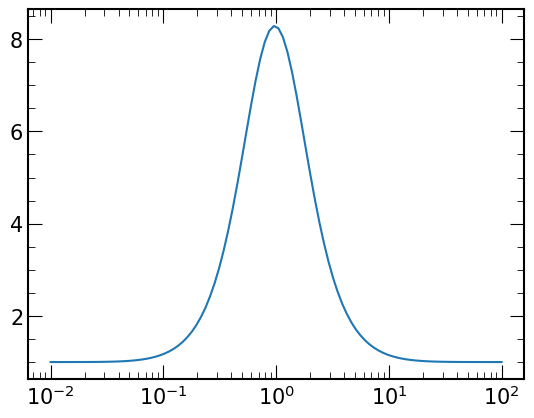

In [2]:
# mass function: gaussian in logM, mean/variance taken from Georgiev catalogue normal dist fit
def mass_function(logmass):
    # currently using a NSC cut fit
    mean = 4.987311450993631 - 5
    variance = 0.18871641457327373
    return 1/np.sqrt(2*np.pi*variance) * np.exp(-(logmass-mean)**2 / (2*variance))

# testing it out with a plot of the mass function
test_masses = np.logspace(-2, 2, 100)
plt.plot(test_masses, 10**mass_function(np.log10(test_masses)))
plt.xscale('log')
plt.show()

# custom merge function
def merge_energy(sim_pointer, collided_particles_index):
    sim = sim_pointer.contents
    ps = sim.particles
    
    i = collided_particles_index.p1
    j = collided_particles_index.p2
    
    # calculating the relevant energy to see if a merger really should happen or not
    dp = ps[i]-ps[j]
    total_mass = ps[i].m + ps[j].m
    reduced_mass = (ps[i].m*ps[j].m)/total_mass
    r_12 = np.sqrt(dp.x**2 + dp.y**2 + dp.z**2)
    v_12sq = dp.vx**2 + dp.vy**2 + dp.vz**2
    U_12 = -sim.G*ps[i].m*ps[j].m / (r_12**2.11 + (1.7*sim.softening)**2.11)**(1/2.11)
    E_12 = 0.5*reduced_mass*v_12sq + U_12
    #print('merge function called')
    if E_12 < 0:
        # if clusters did meet the energy condition, delete particle j and update particle i to the merged one
        #print(np.sqrt(ps[i].x**2 + ps[i].y**2 + ps[i].z**2), dp.vx, dp.vy, dp.vz)
        old_radius = ps[i].r
        new_particle = (ps[i]*ps[i].m + ps[j]*ps[j].m)/total_mass
        ps[i] = new_particle
        ps[i].m = total_mass
        ps[i].r = 2*2.548e-3*(total_mass/0.1)**(0.242)
        return 2
    else:
        # in case the clusters did pass near each other, but didn't meet the energy condition, do nothing
        return 0

Calculating NFW Energies and Weights


<ipython-input-5-b186b493b1e1>:27: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]


Finished calculating NFW Energies and Weights
5.7895827293396
0.1 5.1


<ipython-input-5-b186b493b1e1>:41: RuntimeWarning: divide by zero encountered in log10
  return 10**np.interp(E, energy_values_NFW, np.log10(energy_weights_NFW))


finished until t = 0.0 0.40642499923706055
finished until t = 0.5 2.8350577354431152
finished until t = 1.0 7.354897737503052
finished until t = 1.5 13.885289907455444
finished until t = 2.0 22.56791090965271
finished until t = 2.5 33.19996118545532
finished until t = 3.0 46.107009410858154
finished until t = 3.5 61.86282515525818
finished until t = 4.0 79.4317512512207
finished until t = 4.5 99.15784978866577
finished until t = 5.0 121.05729150772095
finished until t = 5.5 144.950350522995
finished until t = 6.0 170.9312481880188
finished until t = 6.5 199.04462361335754
finished until t = 7.0 229.36015343666077
finished until t = 7.5 261.73912239074707
finished until t = 8.0 296.38142371177673
finished until t = 8.5 333.1368134021759
finished until t = 9.0 371.9854531288147
finished until t = 9.5 412.93323945999146
finished until t = 10.0 456.0158021450043


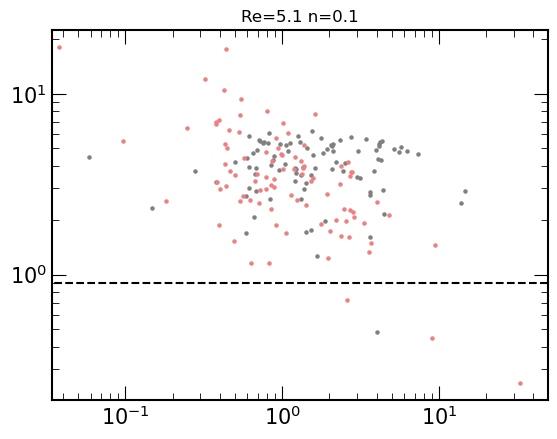

In [5]:
#NFW
#R_e_values = [0.6, 1.1, 1.6, 2.1, 2.6, 3.1, 3.6, 4.1, 4.6, 5]
R_e_values =[5.1]
n_values = [0.1]

for i in range(len(n_values)):
    n = n_values[i]
    for j in range (len(R_e_values)):
        R_e = R_e_values[j]
        
        # NFW ergodic distribution function, calling helpers from NFW_profile_functions.py
        ######################################
        # MAKE SURE THESE rho_0 and r_0 ARE THE SAME AS THE ONES IN THE ADDITIONAL_FORCES FILE
        ######################################

        rho_0_NFW = 17.99 # 10^5 solar masses / kpc^3
        r_0_NFW = 25.34 # kpc
        G = 0.449 # (kpc/Gyr)^2 * kpc / 10^5 solar masses
        Sersic_params_NFW = [R_e, n]
        @np.vectorize
        def NFW_ergodic_f(E):
            def integrand(psi):
                def r_psi(psi):
                    rootfinding_func = lambda r: np.abs(psi + phi_NFW(r, rho_0_NFW, r_0_NFW))  #lambda (def short function) arguments : expression
                    return minimize_scalar(rootfinding_func, method='bounded', bounds=[1e-20, 500]).x
                return np.sqrt(-E-psi)*d3rhodpsi3_NFW(r_psi(psi), rho_0_NFW, r_0_NFW, Sersic_params_NFW[0], Sersic_params_NFW[1])
            return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]

        start = time.time()
        print('Calculating NFW Energies and Weights')
        energy_values_NFW = 4 * np.pi * G * rho_0_NFW * r_0_NFW**2 * np.arange(-1+0.005, -0.005, 0.005)
        energy_weights_NFW = NFW_ergodic_f(energy_values_NFW)
        #E_dist_NFW = [energy_values_NFW, energy_weights_NFW]
        print('Finished calculating NFW Energies and Weights')
        print(time.time()-start)
        print(n, R_e)

        #making interpolated functions for f(E) that can be called in the initialization process for speed

        def NFW_f_interp(E):
            return 10**np.interp(E, energy_values_NFW, np.log10(energy_weights_NFW))
        
    
        #################################
        ## SAVES OUTPUTS FOR EVERY 0.5 Gyr

        def run_sim(potential, force, halo_params, ergodic_f, seed, t):
            start = time.time()
            np.random.seed(seed)

            # usual initialization of the sim, units, etc.
            sim = rebound.Simulation()
            sim.ri_ias15.epsilon = 0 # using fixed timesteps
            #sim.ri_ias15.min_dt = 1e-5
            #sim.ri_ias15.max_dt = 1e-3
            sim.dt = 5e-4 # fine to use this for quick tests, for the actual paper use the min & max above
            sim.G = 0.449 # setting units to kpc, Gyr, 10^5 M_sun
            sim.softening = 0.01 # plummer softening of 10 pc
            sim.collision = "line" # counting collisions as linear interpolations between timesteps
            sim.collision_resolve = merge_energy # conserving mass and momentum, with energy condition for mergers

            # Sersic radial distribution and values to draw positions with their weights

            pos_values = np.arange(1e-4, 10, 1e-4)
            pos_weights = nu(pos_values, R_e, n)*4*np.pi*pos_values**2
            pos_weights /= sum(pos_weights)

            # unpacking halo params
            rho_0 = halo_params[0]
            r_0 = halo_params[1]

            # setting up a mass function gaussian in logM
            logmass_values = np.linspace(-2, 2, 1000)
            logmass_weights = mass_function(logmass_values)
            logmass_weights /= sum(logmass_weights)

            total_GC_mass = 0
            # add particles w/ randomly drawn m, r, v until we reach the UGC7369 total GC mass
            while total_GC_mass < NGC4605_total_mass-10**(4.987311450993631 - 5):
                mass = np.exp(10/23) * 10**np.random.choice(logmass_values, p=logmass_weights) #random value is sampled from the logmass_values array with probabilities defined by the logmass_weights
                pos_rad = np.random.choice(pos_values, p=pos_weights)
                pos_theta = np.random.uniform(0, np.pi)
                pos_phi = np.random.uniform(0, 2*np.pi)
                x_i = pos_rad*np.sin(pos_theta)*np.cos(pos_phi)  #Cartesian coordinates
                y_i = pos_rad*np.sin(pos_theta)*np.sin(pos_phi)
                z_i = pos_rad*np.cos(pos_theta)

                # drawing velocities from provided distribution
                vel_values = np.arange(0.01, 100, 0.01)
                vel_weights = 4*np.pi*vel_values**2 * \
                                ergodic_f(0.5*vel_values**2 + potential(pos_rad, rho_0, r_0))/(nu(pos_rad, R_e, n))
                vel_weights /= sum(vel_weights)
                vel_mag = np.random.choice(vel_values, p=vel_weights)
                v_theta = np.random.uniform(0, np.pi)
                v_phi = np.random.uniform(0, 2*np.pi)
                vx_i = vel_mag * np.sin(v_theta)*np.cos(v_phi)
                vy_i = vel_mag * np.sin(v_theta)*np.sin(v_phi)
                vz_i = vel_mag * np.cos(v_theta)

                sim.add(m = mass, r = 2*2.548e-3*(mass/0.1)**(0.242), \
                        x = x_i, y = y_i, z = z_i, vx = vx_i, vy = vy_i, vz = vz_i)
                total_GC_mass += mass/np.exp(10/23)

            rebx = reboundx.Extras(sim)
            # adding in the additional forces to work with reboundx
            myforce = rebx.create_force("additional_forces")
            myforce.force_type = "vel"
            myforce.update_accelerations = force
            rebx.add_force(myforce)
            # setting up built-in exponential mass loss
            modifymass = rebx.load_operator("modify_mass")
            rebx.add_operator(modifymass)
            # setting the mass-loss timescales of each particle, tau chosen to match linear decrease of 1/3 by end
            for p in sim.particles:
                p.params["tau_mass"] = -23

            # keeping track of initial positions, velocities, and masses
            initial_masses = []
            initial_positions = []
            initial_vels = []

            for p in sim.particles:
                initial_masses.append(p.m)
                initial_positions.append(np.array([p.x, p.y, p.z]))
                initial_vels.append(np.array([p.vx, p.vy, p.vz]))

            # integrating
            sim.integrate(t)

            # keeping track of final positions, velocities, and masses
            final_masses = []
            final_positions = []
            final_vels = []

            for p in sim.particles:
                final_masses.append(p.m)
                final_positions.append(np.array([p.x, p.y, p.z]))
                final_vels.append(np.array([p.vx, p.vy, p.vz]))

            initial_masses, final_masses = np.array(initial_masses), np.array(final_masses)
            initial_positions, final_positions = np.array(initial_positions), np.array(final_positions)
            initial_vels, final_vels = np.array(initial_vels), np.array(final_vels)

            # clearing sim from memory now that we've stored everything important
            sim = None

            # returning 3 sets of 2 things: the initial and final masses, positions, and velocities
            return [initial_masses, final_masses], [initial_positions, final_positions], [initial_vels, final_vels]
        
        ###############################################################################
        ## run N_iterations versions of the sim, outputting every 0.5 Gyrs for 10 Gyrs

        def run_iterations(N_iterations, output_name, potential, force, halo_params, ergodic_f):
            seeds = np.random.randint(1, 4294967295, size = N_iterations)

            start = time.time()

            for output_time, t in enumerate(np.arange(0, 10.5, 0.5)):

                if output_time == 0:
                    # save initial data
                    f = open('Sim_n_'+str(n)+'_'+output_name+'_'+str(output_time)+'_'+str(R_e)+'.txt', 'w')
                    f.write('t = '+str(t)+' Gyr \n')
                    f.write('iteration m x y z vx vy vz n Re \n')
                    for k in range(N_iterations):
                        seed = seeds[k]
                        masses, positions, velocities = run_sim(potential = potential, force = force, \
                                                                halo_params = halo_params, ergodic_f = ergodic_f, \
                                                                seed = seed, t=0.001)
                        for GC_n in range(len(masses[0])):
                            f.write(str(k)+' '+str(masses[0][GC_n])+' '+str(positions[0][GC_n][0])+' '\
                                    +str(positions[0][GC_n][1])+' '+str(positions[0][GC_n][2])+' '\
                                    +str(velocities[0][GC_n][0])+' '+str(velocities[0][GC_n][1])+' '\
                                    +str(velocities[0][GC_n][2])+' '+str(n)+' '+str(R_e)+'\n')
                    f.close()
                else:
                    # save final data
                    f = open('Sim_n_'+str(n)+'_'+output_name+'_'+str(output_time)+'_'+str(R_e)+'.txt', 'w')
                    f.write('t = '+str(t)+' Gyr \n')
                    f.write('iteration m x y z vx vy vz n Re \n')
                    for k in range(N_iterations):
                        seed = seeds[k]
                        masses, positions, velocities = run_sim(potential = potential, force = force, \
                                                                halo_params = halo_params, ergodic_f = ergodic_f, \
                                                                seed = seed, t=t)
                        for GC_n in range(len(masses[1])):
                            f.write(str(k)+' '+str(masses[1][GC_n])+' '+str(positions[1][GC_n][0])+' '\
                                        +str(positions[1][GC_n][1])+' '+str(positions[1][GC_n][2])+' '\
                                        +str(velocities[1][GC_n][0])+' '+str(velocities[1][GC_n][1])+' '\
                                        +str(velocities[1][GC_n][2])+' '+str(n)+' '+str(R_e)+'\n')
                    f.close()
                print('finished until t = '+str(t), str(time.time()-start))

        ##############################################
        #RUNS EVERYTHING 
        
        run_iterations(10, 'NFW-3', phi_NFW, clib_additional_forces.NFW_DF_Petts, [17.99, 25.34], NFW_f_interp)
        data_initial = np.genfromtxt('Sim_n_'+str(n)+'_NFW-3_0'+'_'+str(R_e)+'.txt', skip_header=2)
        initial_masses = data_initial[:, 1]
        initial_radii = np.sqrt(data_initial[:, 2]**2 + data_initial[:, 3]**2 + data_initial[:, 4]**2)
        data_final = np.genfromtxt('Sim_n_'+str(n)+'_NFW-3_20'+'_'+str(R_e)+'.txt', skip_header=2)
        final_masses = data_final[:, 1]
        final_radii = np.sqrt(data_final[:, 2]**2 + data_final[:, 3]**2 + data_final[:, 4]**2)
        
        plt.plot([1e-2, 1e2], [0.9, 0.9], 'k--')
        plt.scatter(initial_masses, initial_radii, color='gray', s=5)
        plt.scatter(final_masses, final_radii, color='lightcoral', s=5)
        #plt.scatter(UGC7369_masses, UGC7369_rperps, color='b', s=5)
        plt.yscale('log')
        plt.xscale('log')
        plt.xlim(min(final_masses)*0.9, max(final_masses)*1.5)
        plt.title('Re='+str(R_e)+' n='+str(n))
        plt.savefig('NFW-3_'+str(n)+'_'+str(R_e)+'.png')
        plt.show()
        
             

In [35]:
# NFW ergodic distribution function, calling helpers from NFW_profile_functions.py

######################################
# MAKE SURE THESE rho_0 and r_0 ARE THE SAME AS THE ONES IN THE ADDITIONAL_FORCES FILE
######################################

rho_0_NFW = 25.82 # 10^5 solar masses / kpc^3
r_0_NFW = 8.89 # kpc
G = 0.449 # (kpc/Gyr)^2 * kpc / 10^5 solar masses
Sersic_params_NFW = [R_e, n]
@np.vectorize
def NFW_ergodic_f(E):
    def integrand(psi):
        def r_psi(psi):
            rootfinding_func = lambda r: np.abs(psi + phi_NFW(r, rho_0_NFW, r_0_NFW))  #lambda (def short function) arguments : expression
            return minimize_scalar(rootfinding_func, method='bounded', bounds=[1e-20, 500]).x
        return np.sqrt(-E-psi)*d3rhodpsi3_NFW(r_psi(psi), rho_0_NFW, r_0_NFW, Sersic_params_NFW[0], Sersic_params_NFW[1])
    return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]

start = time.time()
print('Calculating NFW Energies and Weights')
energy_values_NFW = 4 * np.pi * G * rho_0_NFW * r_0_NFW**2 * np.arange(-1+0.005, -0.005, 0.005)
energy_weights_NFW = NFW_ergodic_f(energy_values_NFW)
#E_dist_NFW = [energy_values_NFW, energy_weights_NFW]
print('Finished calculating NFW Energies and Weights')
print(time.time()-start)

# Burkert ergodic distribution function, calling helpers from Burkert_profile_functions.py
rho_0_Burkert = 318.76 # 10^5 solar masses / kpc^3
r_0_Burkert = 3.36 # kpc
Sersic_params_Burkert = [0.9, 1.18]

@np.vectorize
def Burkert_ergodic_f(E):
    def integrand(psi):
        def r_psi(psi):
            rootfinding_func = lambda r: np.abs(psi + phi_Burkert(r, rho_0_Burkert, r_0_Burkert))
            return minimize_scalar(rootfinding_func, method='bounded', bounds=[1e-20, 500]).x
        return np.sqrt(-E-psi)*d3rhodpsi3_Burkert(r_psi(psi), rho_0_Burkert, r_0_Burkert, Sersic_params_Burkert[0], Sersic_params_Burkert[1])
    return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]

start = time.time()
print('Calculating Burkert Energies and Weights')
energy_values_Burkert = np.pi**2 * G * rho_0_Burkert * r_0_Burkert**2 * np.arange(-1+0.005, -0.005, 0.005)
energy_weights_Burkert = Burkert_ergodic_f(energy_values_Burkert)
#E_dist_Burkert = [energy_values_Burkert, energy_weights_Burkert]
print('Finished calculating Burkert Energies and Weights')
print(time.time()-start)
print(Sersic_params_NFW)

#making interpolated functions for f(E) that can be called in the initialization process for speed

def NFW_f_interp(E):
    return 10**np.interp(E, energy_values_NFW, np.log10(energy_weights_NFW))

def Burkert_f_interp(E):
    return 10**np.interp(E, energy_values_Burkert, np.log10(energy_weights_Burkert))


Calculating NFW Energies and Weights


<ipython-input-35-b46fbd02639c>:18: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]


Finished calculating NFW Energies and Weights
4.360182523727417
Calculating Burkert Energies and Weights
Finished calculating Burkert Energies and Weights
8.970049858093262
[0.1, 0.1]


In [30]:
# saves outputs for every 0.5 Gyr

def run_sim(potential, force, halo_params, ergodic_f, seed, t):
    
    start = time.time()
    
    np.random.seed(seed)
    
    # usual initialization of the sim, units, etc.
    sim = rebound.Simulation()
    sim.ri_ias15.epsilon = 0 # using fixed timesteps
    #sim.ri_ias15.min_dt = 1e-5
    #sim.ri_ias15.max_dt = 1e-3
    sim.dt = 5e-4 # fine to use this for quick tests, for the actual paper use the min & max above
    sim.G = 0.449 # setting units to kpc, Gyr, 10^5 M_sun
    sim.softening = 0.01 # plummer softening of 10 pc
    sim.collision = "line" # counting collisions as linear interpolations between timesteps
    sim.collision_resolve = merge_energy # conserving mass and momentum, with energy condition for mergers
    
    # Sersic radial distribution and values to draw positions with their weights
    
    pos_values = np.arange(1e-4, 10, 1e-4)
    pos_weights = nu(pos_values, R_e, n)*4*np.pi*pos_values**2
    pos_weights /= sum(pos_weights)
    
    # unpacking halo params
    rho_0 = halo_params[0]
    r_0 = halo_params[1]
    
    # setting up a mass function gaussian in logM
    logmass_values = np.linspace(-2, 2, 1000)
    logmass_weights = mass_function(logmass_values)
    logmass_weights /= sum(logmass_weights)
    
    total_GC_mass = 0
    # add particles w/ randomly drawn m, r, v until we reach the UGC7369 total GC mass
    while total_GC_mass < UGC8638_total_mass-10**(4.987311450993631 - 5):
        mass = np.exp(10/23) * 10**np.random.choice(logmass_values, p=logmass_weights) #random value is sampled from the logmass_values array with probabilities defined by the logmass_weights
        pos_rad = np.random.choice(pos_values, p=pos_weights)
        pos_theta = np.random.uniform(0, np.pi)
        pos_phi = np.random.uniform(0, 2*np.pi)
        x_i = pos_rad*np.sin(pos_theta)*np.cos(pos_phi)  #Cartesian coordinates
        y_i = pos_rad*np.sin(pos_theta)*np.sin(pos_phi)
        z_i = pos_rad*np.cos(pos_theta)

        # drawing velocities from provided distribution
        vel_values = np.arange(0.01, 100, 0.01)
        vel_weights = 4*np.pi*vel_values**2 * \
                        ergodic_f(0.5*vel_values**2 + potential(pos_rad, rho_0, r_0))/(nu(pos_rad, R_e, n))
        vel_weights /= sum(vel_weights)
        vel_mag = np.random.choice(vel_values, p=vel_weights)
        v_theta = np.random.uniform(0, np.pi)
        v_phi = np.random.uniform(0, 2*np.pi)
        vx_i = vel_mag * np.sin(v_theta)*np.cos(v_phi)
        vy_i = vel_mag * np.sin(v_theta)*np.sin(v_phi)
        vz_i = vel_mag * np.cos(v_theta)
        
        sim.add(m = mass, r = 2*2.548e-3*(mass/0.1)**(0.242), \
                x = x_i, y = y_i, z = z_i, vx = vx_i, vy = vy_i, vz = vz_i)
        total_GC_mass += mass/np.exp(10/23)
    
    rebx = reboundx.Extras(sim)
    # adding in the additional forces to work with reboundx
    myforce = rebx.create_force("additional_forces")
    myforce.force_type = "vel"
    myforce.update_accelerations = force
    rebx.add_force(myforce)
    # setting up built-in exponential mass loss
    modifymass = rebx.load_operator("modify_mass")
    rebx.add_operator(modifymass)
    # setting the mass-loss timescales of each particle, tau chosen to match linear decrease of 1/3 by end
    for p in sim.particles:
        p.params["tau_mass"] = -23
    
    # keeping track of initial positions, velocities, and masses
    initial_masses = []
    initial_positions = []
    initial_vels = []

    for p in sim.particles:
        initial_masses.append(p.m)
        initial_positions.append(np.array([p.x, p.y, p.z]))
        initial_vels.append(np.array([p.vx, p.vy, p.vz]))
    
    # integrating
    sim.integrate(t)
    
    # keeping track of final positions, velocities, and masses
    final_masses = []
    final_positions = []
    final_vels = []

    for p in sim.particles:
        final_masses.append(p.m)
        final_positions.append(np.array([p.x, p.y, p.z]))
        final_vels.append(np.array([p.vx, p.vy, p.vz]))
    
    initial_masses, final_masses = np.array(initial_masses), np.array(final_masses)
    initial_positions, final_positions = np.array(initial_positions), np.array(final_positions)
    initial_vels, final_vels = np.array(initial_vels), np.array(final_vels)
    
    # clearing sim from memory now that we've stored everything important
    sim = None
    
    # returning 3 sets of 2 things: the initial and final masses, positions, and velocities
    return [initial_masses, final_masses], [initial_positions, final_positions], [initial_vels, final_vels]

In [31]:
# run N_iterations versions of the sim, outputting every 0.5 Gyrs for 10 Gyrs

def run_iterations(N_iterations, output_name, potential, force, halo_params, ergodic_f):
    seeds = np.random.randint(1, 4294967295, size = N_iterations)
    
    start = time.time()
    
    for output_time, t in enumerate(np.arange(0, 10.5, 0.5)):
        
        if output_time == 0:
            # save initial data
            f = open('Sim_n_'+str(n)+'_'+output_name+'_'+str(output_time)+'_'+str(R_e)+'.txt', 'w')
            f.write('t = '+str(t)+' Gyr \n')
            f.write('iteration m x y z vx vy vz n Re \n')
            for k in range(N_iterations):
                seed = seeds[k]
                masses, positions, velocities = run_sim(potential = potential, force = force, \
                                                        halo_params = halo_params, ergodic_f = ergodic_f, \
                                                        seed = seed, t=0.001)
                for GC_n in range(len(masses[0])):
                    f.write(str(k)+' '+str(masses[0][GC_n])+' '+str(positions[0][GC_n][0])+' '\
                            +str(positions[0][GC_n][1])+' '+str(positions[0][GC_n][2])+' '\
                            +str(velocities[0][GC_n][0])+' '+str(velocities[0][GC_n][1])+' '\
                            +str(velocities[0][GC_n][2])+' '+str(n)+' '+str(R_e)+'\n')
            f.close()
        else:
            # save final data
            f = open('Sim_n_'+str(n)+'_'+output_name+'_'+str(output_time)+'_'+str(R_e)+'.txt', 'w')
            f.write('t = '+str(t)+' Gyr \n')
            f.write('iteration m x y z vx vy vz n Re \n')
            for k in range(N_iterations):
                seed = seeds[k]
                masses, positions, velocities = run_sim(potential = potential, force = force, \
                                                        halo_params = halo_params, ergodic_f = ergodic_f, \
                                                        seed = seed, t=t)
                for GC_n in range(len(masses[1])):
                    f.write(str(k)+' '+str(masses[1][GC_n])+' '+str(positions[1][GC_n][0])+' '\
                                +str(positions[1][GC_n][1])+' '+str(positions[1][GC_n][2])+' '\
                                +str(velocities[1][GC_n][0])+' '+str(velocities[1][GC_n][1])+' '\
                                +str(velocities[1][GC_n][2])+' '+str(n)+' '+str(R_e)+'\n')
            f.close()
        print('finished until t = '+str(t), str(time.time()-start))

In [33]:
#NFW
#R_e_values = np.arange(0.1, 10.6, 0.5)
R_e = [2]
n_values = [0.1]

for i in range(len(n_values)):
    n = n_values[i]
    for j in range (len(R_e_values)):
        R_e = R_e_values[j]
        
        run_iterations(10, 'NFW-2', phi_NFW, clib_additional_forces.NFW_DF_Petts, [25.82, 8.89], NFW_f_interp)
        data_initial = np.genfromtxt('Sim_n_'+str(n)+'_NFW-2_0'+'_'+str(R_e)+'.txt', skip_header=2)
        initial_masses = data_initial[:, 1]
        initial_radii = np.sqrt(data_initial[:, 2]**2 + data_initial[:, 3]**2 + data_initial[:, 4]**2)
        data_final = np.genfromtxt('Sim_n_'+str(n)+'_NFW-2_20'+'_'+str(R_e)+'.txt', skip_header=2)
        final_masses = data_final[:, 1]
        final_radii = np.sqrt(data_final[:, 2]**2 + data_final[:, 3]**2 + data_final[:, 4]**2)
        
        plt.plot([1e-2, 1e2], [0.9, 0.9], 'k--')
        plt.scatter(initial_masses, initial_radii, color='gray', s=5)
        plt.scatter(final_masses, final_radii, color='lightcoral', s=5)
        #plt.scatter(UGC7369_masses, UGC7369_rperps, color='b', s=5)
        plt.yscale('log')
        plt.xscale('log')
        plt.xlim(min(final_masses)*0.9, max(final_masses)*1.5)
        plt.title('Re='+str(R_e)+' n='+str(n))
        plt.savefig('NFW-1_'+str(n)+'_'+str(R_e)+'.png')
        plt.show()
        
             

<ipython-input-26-a0e166411cac>:53: RuntimeWarning: divide by zero encountered in log10
  return 10**np.interp(E, energy_values_NFW, np.log10(energy_weights_NFW))


[1.27331941e-09 5.09327765e-09 1.14598747e-08 ... 3.68585416e-15
 3.64641956e-15 3.60740284e-15]
[1.03474830e-09 4.13899318e-09 9.31273466e-09 ... 3.61032005e-15
 3.57169358e-15 3.53347643e-15]
[1.18149558e-09 4.72596641e-09 1.06333648e-08 ... 3.72063718e-15
 3.68083044e-15 3.64094828e-15]
[1.06960508e-09 4.27842034e-09 9.62644576e-09 ... 3.62076936e-15
 3.58203109e-15 3.54370333e-15]
[1.15899275e-09 4.63597101e-09 1.04309348e-08 ... 3.64949531e-15
 3.61044971e-15 3.57181787e-15]
[1.04593967e-09 4.18375867e-09 9.41345700e-09 ... 3.61360470e-15
 3.57494309e-15 3.53669117e-15]
[1.27213356e-09 5.08851712e-09 1.14490993e-08 ... 3.70960465e-15
 3.66991594e-15 3.63064781e-15]
[1.02842098e-09 4.11368392e-09 9.25578883e-09 ... 3.60849657e-15
 3.56988961e-15 3.53169176e-15]
[1.28128791e-09 5.12515163e-09 1.15315912e-08 ... 3.68818825e-15
 3.64872868e-15 3.60968725e-15]
[1.22539472e-09 4.90157887e-09 1.10285525e-08 ... 3.67108149e-15
 3.63180494e-15 3.59294460e-15]
[1.25454932e-09 5.01819729e-09

KeyboardInterrupt: 

In [6]:
#Burket

for i in range(len(n_values)):
    n = n_values[i]
    for j in range (len(R_e_values)):
        R_e = R_e_values[j]
        UGC7369_R_e = R_e
        # projected separation divided by effective radius from Georgiev
        UGC7369_rperps_norms =  np.array([2.23066667, 1.428     , 0.99866667, 1.96933333, 1.97866667,
               0.63466667, 0.13066667, 0.00933333, 0.24266667, 0.364     ,
               1.372     , 0.42      , 0.644     , 0.37333333, 0.42      ,
               0.82133333, 0.99866667, 1.77333333, 0.868     , 1.148     ,
               1.22266667])
        # physical projected radii
        UGC7369_rperps = UGC7369_rperps_norms*UGC7369_R_e
        
        
                # Burkert ergodic distribution function, calling helpers from Burkert_profile_functions.py
        rho_0_Burkert = 318.76 # 10^5 solar masses / kpc^3
        r_0_Burkert = 3.36 # kpc
        Sersic_params_Burkert = [0.9, 1.18]

        @np.vectorize
        def Burkert_ergodic_f(E):
            def integrand(psi):
                def r_psi(psi):
                    rootfinding_func = lambda r: np.abs(psi + phi_Burkert(r, rho_0_Burkert, r_0_Burkert))
                    return minimize_scalar(rootfinding_func, method='bounded', bounds=[1e-20, 500]).x
                return np.sqrt(-E-psi)*d3rhodpsi3_Burkert(r_psi(psi), rho_0_Burkert, r_0_Burkert, Sersic_params_Burkert[0], Sersic_params_Burkert[1])
            return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]

        start = time.time()
        print('Calculating Burkert Energies and Weights')
        energy_values_Burkert = np.pi**2 * G * rho_0_Burkert * r_0_Burkert**2 * np.arange(-1+0.005, -0.005, 0.005)
        energy_weights_Burkert = Burkert_ergodic_f(energy_values_Burkert)
        #E_dist_Burkert = [energy_values_Burkert, energy_weights_Burkert]
        print('Finished calculating Burkert Energies and Weights')
        print(time.time()-start)
        
        def Burkert_f_interp(E):
            return 10**np.interp(E, energy_values_Burkert, np.log10(energy_weights_Burkert))
        
        
        run_iterations(10, 'Burkert-1', phi_Burkert, clib_additional_forces.Burkert_DF_Petts, [318.76, 3.36], Burkert_f_interp)
        data_initial = np.genfromtxt('Sim_n_'+str(n)+'_Burkert-1_0'+'_'+str(R_e)+'.txt', skip_header=2)
        initial_masses = data_initial[:, 1]
        initial_radii = np.sqrt(data_initial[:, 2]**2 + data_initial[:, 3]**2 + data_initial[:, 4]**2)
        data_final = np.genfromtxt('Sim_n_'+str(n)+'_Burkert-1_20'+'_'+str(R_e)+'.txt', skip_header=2)
        final_masses = data_final[:, 1]
        final_radii = np.sqrt(data_final[:, 2]**2 + data_final[:, 3]**2 + data_final[:, 4]**2)

        plt.plot([1e-2, 1e2], [0.9, 0.9], 'k--')
        plt.scatter(initial_masses, initial_radii, color='gray', s=5)
        plt.scatter(final_masses, final_radii, color='lightcoral', s=5)
        plt.scatter(UGC7369_masses, UGC7369_rperps, color='b', s=5)
        plt.yscale('log')
        plt.xscale('log')
        plt.xlim(min(final_masses)*0.9, max(final_masses)*1.5)
        plt.title('Re='+str(R_e)+' n='+str(n))
        plt.savefig('Burkert-1_'+str(n)+'_'+str(R_e)+'.png')
        plt.show()

NameError: name 'R_e_values' is not defined